Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
from google.colab import drive

**Step 1: Load the Dataset Path**

In [2]:
dataset_path = "/content/drive/MyDrive/CVPR /Animals"  # Replace with your dataset folder path

**Step 2: Image Preprocessing.**

(Convert the images into Grayscale)

In [3]:
from tqdm import tqdm

def load_images_from_folder(archive_path, img_size=(360, 360)):
    images, labels = [], []
    supported_formats = ('.jpg', '.jpeg', '.png', '.bmp')

    for category in os.listdir(archive_path):
        category_path = os.path.join(archive_path, category)
        if os.path.isdir(category_path):
            for filename in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
                img_path = os.path.join(category_path, filename)
                if filename.lower().endswith(supported_formats):
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, img_size)
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        images.append(img)
                        labels.append(category)
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    return np.array(images), np.array(labels)

# Example usage
archive_path = "/content/drive/MyDrive/CVPR /Animals"

if os.path.exists(archive_path):
    images, labels = load_images_from_folder(archive_path)
    if len(images) > 0:
        print(f"Loaded {len(images)} images with shape {images[0].shape} and {len(labels)} labels.")
    else:
        print("No images were loaded. Please check the archive path and image formats.")
else:
    print(f"Error: Archive path '{archive_path}' does not exist.")

Loading Jaguar: 100%|██████████| 30/30 [00:00<00:00, 45.98it/s]

Loaded 170 images with shape (360, 360, 3) and 170 labels.


Print Image

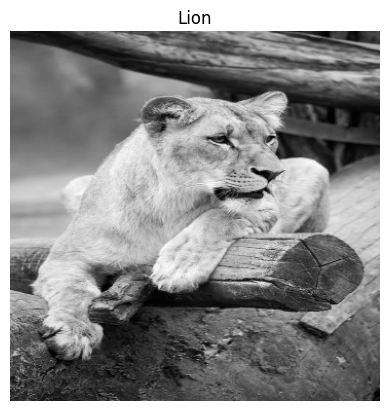

In [4]:
# Convert the first image to grayscale
gray_image = cv2.cvtColor(images[0], cv2.COLOR_RGB2GRAY)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title(labels[0])
plt.axis('off')  # Hide the axis
plt.show()

**Step 3: 5-Fold Cross Validation.**

*Spliting the Datasets into 5 Folds. one as the Validation and Remaining 4 folds for the Training*.

In [5]:
# Flatten and normalize images
num_samples = images.shape[0]
flattened_images = images.reshape(num_samples, -1) / 255.0
encoded_labels = LabelEncoder().fit_transform(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list = []

# Enumerate the folds for tracking the fold number
for fold, (train_idx, val_idx) in enumerate(kf.split(flattened_images)):
    X_train, X_val = flattened_images[train_idx], flattened_images[val_idx]
    y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]

    correct_predictions = 0
    for test_image, true_label in zip(X_val, y_val):
        nearest_neighbor = X_train[np.argmin([np.linalg.norm(test_image - train_image) for train_image in X_train])]
        predicted_label = y_train[np.where(X_train == nearest_neighbor)[0][0]]
        correct_predictions += (predicted_label == true_label)

    fold_accuracy = correct_predictions / len(X_val)
    accuracy_list.append(fold_accuracy)
    print(f"Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

print(f"\nAverage Accuracy across 5 folds: {np.mean(accuracy_list):.4f}")

Accuracy for Fold 1: 0.2941
Accuracy for Fold 2: 0.2059
Accuracy for Fold 3: 0.1471
Accuracy for Fold 4: 0.1765
Accuracy for Fold 5: 0.1176

Average Accuracy across 5 folds: 0.1882


**Step 4: k-NN Classification with Euclidean Distance**

Calculating the accuracy of each fold for each K value.

K Values = 1 to 30

In [6]:
from collections import Counter

k_values = [3, 5, 9, 11, 13, 18, 21, 25]

# Initialize dictionary to store accuracies for each K value
accuracy_results = {k: [] for k in k_values}

# Function to calculate Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
num_samples = len(flattened_images)

for k in k_values:
    print(f"\nEvaluating for K = {k}")
    accuracy_list = []

    # Iterate over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(flattened_images)):
        print(f"  Fold {fold + 1}")

        # Split into training and validation sets
        X_train, X_val = flattened_images[train_idx], flattened_images[val_idx]
        y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]

        correct_predictions = 0

        # Iterate through each validation sample
        for i in range(len(X_val)):
            test_image = X_val[i]
            true_label = y_val[i]

            # Calculate Euclidean distances to all training images
            distances = [euclidean_distance(test_image, train_image) for train_image in X_train]

            # Get indices of the K nearest neighbors
            nearest_indices = np.argsort(distances)[:k]
            nearest_labels = [y_train[idx] for idx in nearest_indices]

            # Determine the most common label among the K nearest neighbors
            predicted_label = Counter(nearest_labels).most_common(1)[0][0]

            # Check if prediction is correct
            if predicted_label == true_label:
                correct_predictions += 1

        # Calculate accuracy for the current fold
        fold_accuracy = correct_predictions / len(X_val)
        accuracy_list.append(fold_accuracy)
        print(f"    Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")

    # Store accuracies for the current K value
    accuracy_results[k] = accuracy_list
    average_accuracy = np.mean(accuracy_list)
    print(f"  Average Accuracy for K = {k}: {average_accuracy:.4f}")

# Calculate the centroid (mean of accuracies) for each K
centroid_results = {k: np.mean(accuracy_results[k]) for k in k_values}

# Display results
print("\nSummary of Average Accuracy and Centroid for K values")
for k in k_values:
    avg_acc = centroid_results[k]
    print(f"K = {k}: Centroid (Mean Accuracy) = {avg_acc:.4f}")


Evaluating for K = 3
  Fold 1
    Accuracy for Fold 1: 0.2353
  Fold 2
    Accuracy for Fold 2: 0.1765
  Fold 3
    Accuracy for Fold 3: 0.2059
  Fold 4
    Accuracy for Fold 4: 0.2647
  Fold 5
    Accuracy for Fold 5: 0.0588
  Average Accuracy for K = 3: 0.1882

Evaluating for K = 5
  Fold 1
    Accuracy for Fold 1: 0.2059
  Fold 2
    Accuracy for Fold 2: 0.1176
  Fold 3
    Accuracy for Fold 3: 0.2647
  Fold 4
    Accuracy for Fold 4: 0.2647
  Fold 5
    Accuracy for Fold 5: 0.1765
  Average Accuracy for K = 5: 0.2059

Evaluating for K = 9
  Fold 1
    Accuracy for Fold 1: 0.1765
  Fold 2
    Accuracy for Fold 2: 0.2353
  Fold 3
    Accuracy for Fold 3: 0.1765
  Fold 4
    Accuracy for Fold 4: 0.2059
  Fold 5
    Accuracy for Fold 5: 0.1471
  Average Accuracy for K = 9: 0.1882

Evaluating for K = 11
  Fold 1
    Accuracy for Fold 1: 0.3235
  Fold 2
    Accuracy for Fold 2: 0.2059
  Fold 3
    Accuracy for Fold 3: 0.1765
  Fold 4
    Accuracy for Fold 4: 0.2059
  Fold 5
    Accuracy

**Step 5: Plotting the Results**

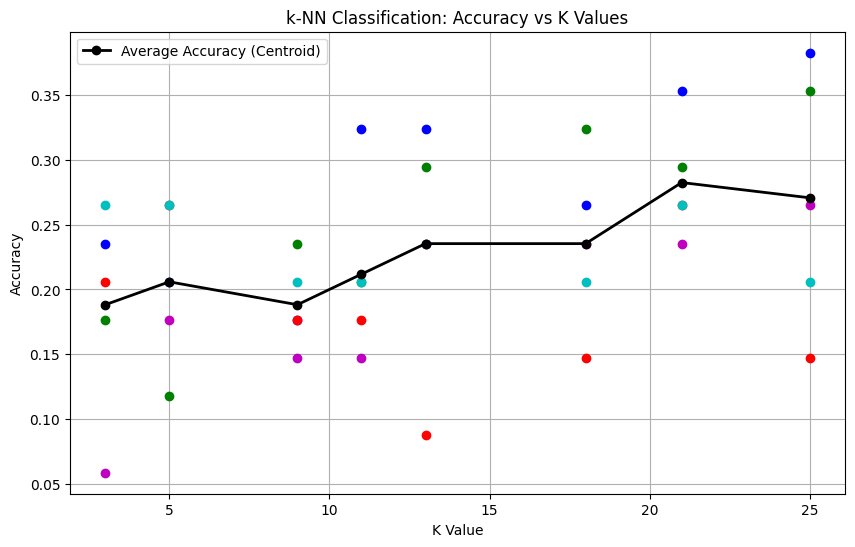

In [16]:
# Prepare data for plotting
k_values = list(accuracy_results.keys())  # K values
centroid_accuracies = [np.mean(accuracy_results[k]) for k in k_values]  # Average accuracy (centroid) for each K

# Color palette for 5 folds
fold_colors = ['b', 'g', 'r', 'c', 'm']  # Blue, Green, Red, Cyan, Magenta

# Plotting
plt.figure(figsize=(10, 6))

# Plot individual fold accuracies with different colors for each fold
for k in k_values:
    for i, acc in enumerate(accuracy_results[k]):
        plt.plot([k], [acc], 'o', color=fold_colors[i], label=f'Fold {i+1} Accuracy (K={k})' if k == 1 else "")

# Plot the centroid (average) accuracy
plt.plot(k_values, centroid_accuracies, marker='o', linestyle='-', color='k', label='Average Accuracy (Centroid)', linewidth=2)

# Adding titles and labels
plt.title('k-NN Classification: Accuracy vs K Values')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the legend
plt.legend(loc='upper left')

# Display the plot
plt.show()